In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load Data

In [2]:
raw = pd.read_csv('../src/data/mta_data_march_cleaned.csv')
    
raw.head()


C/A  UNIT       SCP STATION      start_datetime        end_datetime  \
0  A002  R051  02-00-00   59 ST 2019-02-23 03:00:00 2019-02-23 07:00:00   
1  A002  R051  02-00-00   59 ST 2019-02-23 07:00:00 2019-02-23 11:00:00   
2  A002  R051  02-00-00   59 ST 2019-02-23 11:00:00 2019-02-23 15:00:00   
3  A002  R051  02-00-00   59 ST 2019-02-23 15:00:00 2019-02-23 19:00:00   
4  A002  R051  02-00-00   59 ST 2019-02-23 19:00:00 2019-02-23 23:00:00   

  time_interval  entries  
0      04:00:00     11.0  
1      04:00:00     60.0  
2      04:00:00    160.0  
3      04:00:00    290.0  
4      04:00:00    143.0

# 2. Add Weekday

In [3]:
raw['weekday'] = raw.start_datetime.dt.weekday < 5


In [6]:
raw.weekday.value_counts()


True     779786
False    309866
Name: weekday, dtype: int64

# 3. Do Stations Follow One Time Schedule?

In [8]:
by_window = raw.groupby(['STATION', 'weekday', raw.start_datetime.dt.hour, raw.end_datetime.dt.hour])\
    .agg({ 'entries': ['sum', 'count'] })\
    .reset_index()

In [9]:
by_window.columns = ['_'.join(col).strip() for col in by_window.columns.values]
by_window = by_window.rename(columns={
    'STATION_': 'station',
    'start_datetime_': 'start_datetime',
    'end_datetime_': 'end_datetime',
    'weekday_': 'weekday'
})


In [10]:
by_window[by_window.station == '1 AV']


station  weekday  start_datetime  end_datetime  entries_sum  entries_count
0     1 AV    False               0             3       342.00             40
1     1 AV    False               0             4      1763.00             50
2     1 AV    False               3             7         2.00             50
3     1 AV    False               4             8       405.00             50
4     1 AV    False               7            11         5.00             50
5     1 AV    False               8            12      2849.00             50
6     1 AV    False              11            15        10.00             50
7     1 AV    False              12            16      6204.00             50
8     1 AV    False              15            19        12.00             50
9     1 AV    False              16            20      6966.00             50
10    1 AV    False              19            23         9.00             50
11    1 AV    False              20            23      5054.00             50
12    1 AV    False              23            23         1.00             50
13    1 AV     True               0             3       695.25            100
14    1 AV     True               0             4      3044.50            150
15    1 AV     True               3             7      4422.00            100
16    1 AV     True               4             8     21100.00            150
17    1 AV     True               7            11     52682.00             95
18    1 AV     True               8             9       919.00             10
19    1 AV     True               8            12     71334.00            145
20    1 AV     True              11            15     33615.00            100
21    1 AV     True              12            16     66482.00            145
22    1 AV     True              12            20      4800.00              5
23    1 AV     True              15            19     67439.00            100
24    1 AV     True              16            20     89869.00            144
25    1 AV     True              19            23     38140.00            100
26    1 AV     True              20            23     40718.00            140
27    1 AV     True              23            23      1382.00            100

#### Conclusion

Can NOT assume that each station follows either the 0-4 time period or the 23-3 pattern. 

# 4. What's the Distribution Across Time Schedules?

In [15]:
by_window.end_datetime.value_counts().to_dict()

{23: 2270,
 8: 886,
 12: 877,
 16: 866,
 20: 817,
 4: 756,
 5: 638,
 11: 606,
 7: 573,
 9: 543,
 15: 543,
 19: 538,
 13: 509,
 17: 506,
 21: 473,
 3: 465,
 1: 406,
 10: 136,
 6: 131,
 14: 131,
 18: 106,
 22: 94,
 2: 54,
 0: 42}

In [21]:
# Ommit 23 hour because it's overrepresented by splitting records that overlapped a day
# Choose 5 times for each schedule to compare apples to apples
four_am_schedule = [4, 8, 12, 16, 20]
three_am_schedule = [3, 7, 11, 15, 19]
five_am_schedule = [5, 9, 13, 17, 21]
two_am_schedule = [2, 6, 10, 14, 18]

number_of_records_by_hour = raw.end_datetime.dt.hour.value_counts().to_dict()

for start_hour, schedule in [('4', four_am_schedule), ('3', three_am_schedule), ('5', one_am_schedule), ('2', two_am_schedule)]:
    total = sum([number_of_records_by_hour[hour] for hour in number_of_records_by_hour if hour in schedule])
    print(f'Record count for {start_hour}am schedule:', total)
    

Record count for 4am schedule: 400254
Record count for 3am schedule: 202881
Record count for 5am schedule: 167440
Record count for 2am schedule: 30122


#### Discussion

Roughly 1/2 the values fall along the 4am schedule. Roughly 1/4 fall along the 3am or 5am schedule. The 2am schedule is an order of magnitude less and in less important to consider

Options:
1. Split the entrants proportionally along every hour -> Will misrepresent commuter times (i.e. entrants are not equal 4am-8am)
2. Only use the 4am schedule -> miss half the data
3. Add the non-4am schedule records, to the nearest 4am schedule time interval

While imperfect, we felt the best solution was option 3. Given the vast majority of the data is only one hour on either side of the 4am based intervals, aggregating in this way should be sufficiently accurate. In addition, it creates a clean way to express and explain the data.

# 5. Code Time of Day For Each Record

In [29]:
def get_time_of_day(row):
    if (row.start_datetime.hour >= 2) and (row.end_datetime.hour <= 9):
        return 'early_morning'
    elif (row.start_datetime.hour >= 6) and (row.end_datetime.hour <= 13):
            return 'late_morning'
    elif (row.start_datetime.hour >= 10) and (row.end_datetime.hour <= 17):
            return 'afternoon'
    elif (row.start_datetime.hour >= 14) and (row.end_datetime.hour <= 21):
            return 'evening'
    else:
        return 'other'

In [30]:
raw['time_of_day'] = raw.apply(get_time_of_day, axis=1) # takes awhile. Might not scale

In [31]:
raw.head()

C/A  UNIT       SCP STATION      start_datetime        end_datetime  \
0  A002  R051  02-00-00   59 ST 2019-02-23 03:00:00 2019-02-23 07:00:00   
1  A002  R051  02-00-00   59 ST 2019-02-23 07:00:00 2019-02-23 11:00:00   
2  A002  R051  02-00-00   59 ST 2019-02-23 11:00:00 2019-02-23 15:00:00   
3  A002  R051  02-00-00   59 ST 2019-02-23 15:00:00 2019-02-23 19:00:00   
4  A002  R051  02-00-00   59 ST 2019-02-23 19:00:00 2019-02-23 23:00:00   

  time_interval  entries  weekday    time_of_day  
0      04:00:00     11.0    False  early_morning  
1      04:00:00     60.0    False   late_morning  
2      04:00:00    160.0    False      afternoon  
3      04:00:00    290.0    False        evening  
4      04:00:00    143.0    False          other

# 6. Calculate Avg Entries for Each Time Period

In [34]:
by_day_and_time = raw.groupby(['STATION', 'weekday', raw.start_datetime.dt.date, 'time_of_day']).agg({ 'entries': 'sum'}).reset_index()

In [38]:
by_day_and_time.sample(20)

STATION  weekday start_datetime    time_of_day   entries
55050       PATH WTC 2     True     2019-03-05        evening   2244.00
6294            183 ST     True     2019-03-29          other    102.00
899             111 ST    False     2019-03-09          other   1010.25
65970        ZEREGA AV     True     2019-03-26          other    147.00
9157             28 ST     True     2019-03-05      afternoon  10457.00
42480   HOWARD BCH JFK     True     2019-03-06   late_morning    801.00
44173   JAMAICA VAN WK    False     2019-03-16   late_morning   1032.00
28791     BROADWAY JCT    False     2019-03-24      afternoon   1500.00
61360  THIRTY THIRD ST     True     2019-03-08  early_morning   1539.00
59416      SOUTH FERRY     True     2019-03-04  early_morning   1862.00
55415  PELHAM BAY PARK     True     2019-03-08        evening   1249.00
14734       57 ST-7 AV     True     2019-02-28          other  12140.25
10020            33 ST     True     2019-03-01  early_morning   1502.00
23039         AVENUE P    False     2019-03-23   late_morning      0.00
21310         ASTOR PL    False     2019-02-23        evening   2535.00
27797    BOWLING GREEN     True     2019-03-11  early_morning   2062.00
34616    CYPRESS HILLS     True     2019-03-08      afternoon    239.00
56938         RALPH AV    False     2019-03-24      afternoon    875.00
38025       FORDHAM RD    False     2019-02-24  early_morning    695.00
2341             14 ST     True     2019-02-28  early_morning   1484.00

In [39]:
only_weekdays = by_day_and_time[by_day_and_time.weekday]

In [53]:
avg_by_time = only_weekdays.groupby(['STATION', 'time_of_day']).agg({ 'entries': 'mean' }).reset_index()

In [54]:
avg_by_time.head()

STATION    time_of_day  entries
0    1 AV      afternoon  4003.88
1    1 AV  early_morning  1057.64
2    1 AV        evening  6292.32
3    1 AV   late_morning  4960.64
4    1 AV          other  3551.19

In [55]:
avg_by_time.describe()

entries
count   1890.000000
mean    3137.850886
std     5182.619696
min        2.760000
25%      695.040000
50%     1565.806667
75%     3411.440000
max    67794.720000

The max is ~5 people per second (which seems reasonable)

# 7. Plot Recommended Stations

In [56]:
# top_20 = [
#     '34 ST-PENN STA',
#      'GRD CNTRL-42 ST',
# #      '34 ST-HERALD SQ',
# #      '23 ST',
#      '42 ST-PORT AUTH',
#      '14 ST-UNION SQ',
#      'TIMES SQ-42 ST',
#      'FULTON ST',
#      '86 ST',
#      '125 ST',
#      'CANAL ST',
#      '59 ST COLUMBUS',
#      '59 ST',
#      '14 ST',
#      '96 ST',
#      'CHAMBERS ST',
#      'FLUSHING-MAIN',
#      '47-50 STS ROCK',
#      'JKSN HT-ROOSVLT',
#      '50 ST'
# ]
recommended = ['CHAMBERS ST', 'GRD CNTRL-42 ST', 'FULTON ST', '47-50 STS ROCK', '23 ST', '34 ST-PENN STA']

In [57]:
to_chart = avg_by_time[(avg_by_time.STATION.isin(recommended))& (avg_by_time.time_of_day != 'other')]

In [60]:
to_chart.head()

STATION    time_of_day   entries
230           23 ST      afternoon  25412.08
231           23 ST  early_morning   5279.76
232           23 ST        evening  50259.88
233           23 ST   late_morning  20076.48
305  34 ST-PENN STA      afternoon  25811.28

In [62]:
to_chart['total'] = to_chart.groupby(['STATION'])['entries'].transform('sum')

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
to_chart['percent'] = to_chart['entries'] / to_chart['total']

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
to_chart.head()

STATION    time_of_day   entries      total   percent
230           23 ST      afternoon  25412.08  101028.20  0.251535
231           23 ST  early_morning   5279.76  101028.20  0.052260
232           23 ST        evening  50259.88  101028.20  0.497484
233           23 ST   late_morning  20076.48  101028.20  0.198722
305  34 ST-PENN STA      afternoon  25811.28  145735.12  0.177111

In [66]:
by_percent = to_chart.pivot(index='STATION', columns='time_of_day', values='percent').reset_index()

In [68]:
by_percent.head(6)

time_of_day          STATION  afternoon  early_morning   evening  late_morning
0                      23 ST   0.251535       0.052260  0.497484      0.198722
1             34 ST-PENN STA   0.177111       0.142464  0.291376      0.389050
2             47-50 STS ROCK   0.201865       0.010701  0.725172      0.062263
3                CHAMBERS ST   0.266520       0.026847  0.552744      0.153889
4                  FULTON ST   0.233380       0.081482  0.514990      0.170149
5            GRD CNTRL-42 ST   0.214103       0.090780  0.475179      0.219938

In [73]:
by_percent['total_morning'] = by_percent.early_morning + by_percent.late_morning
by_percent = by_percent.sort_values(['total_morning'])

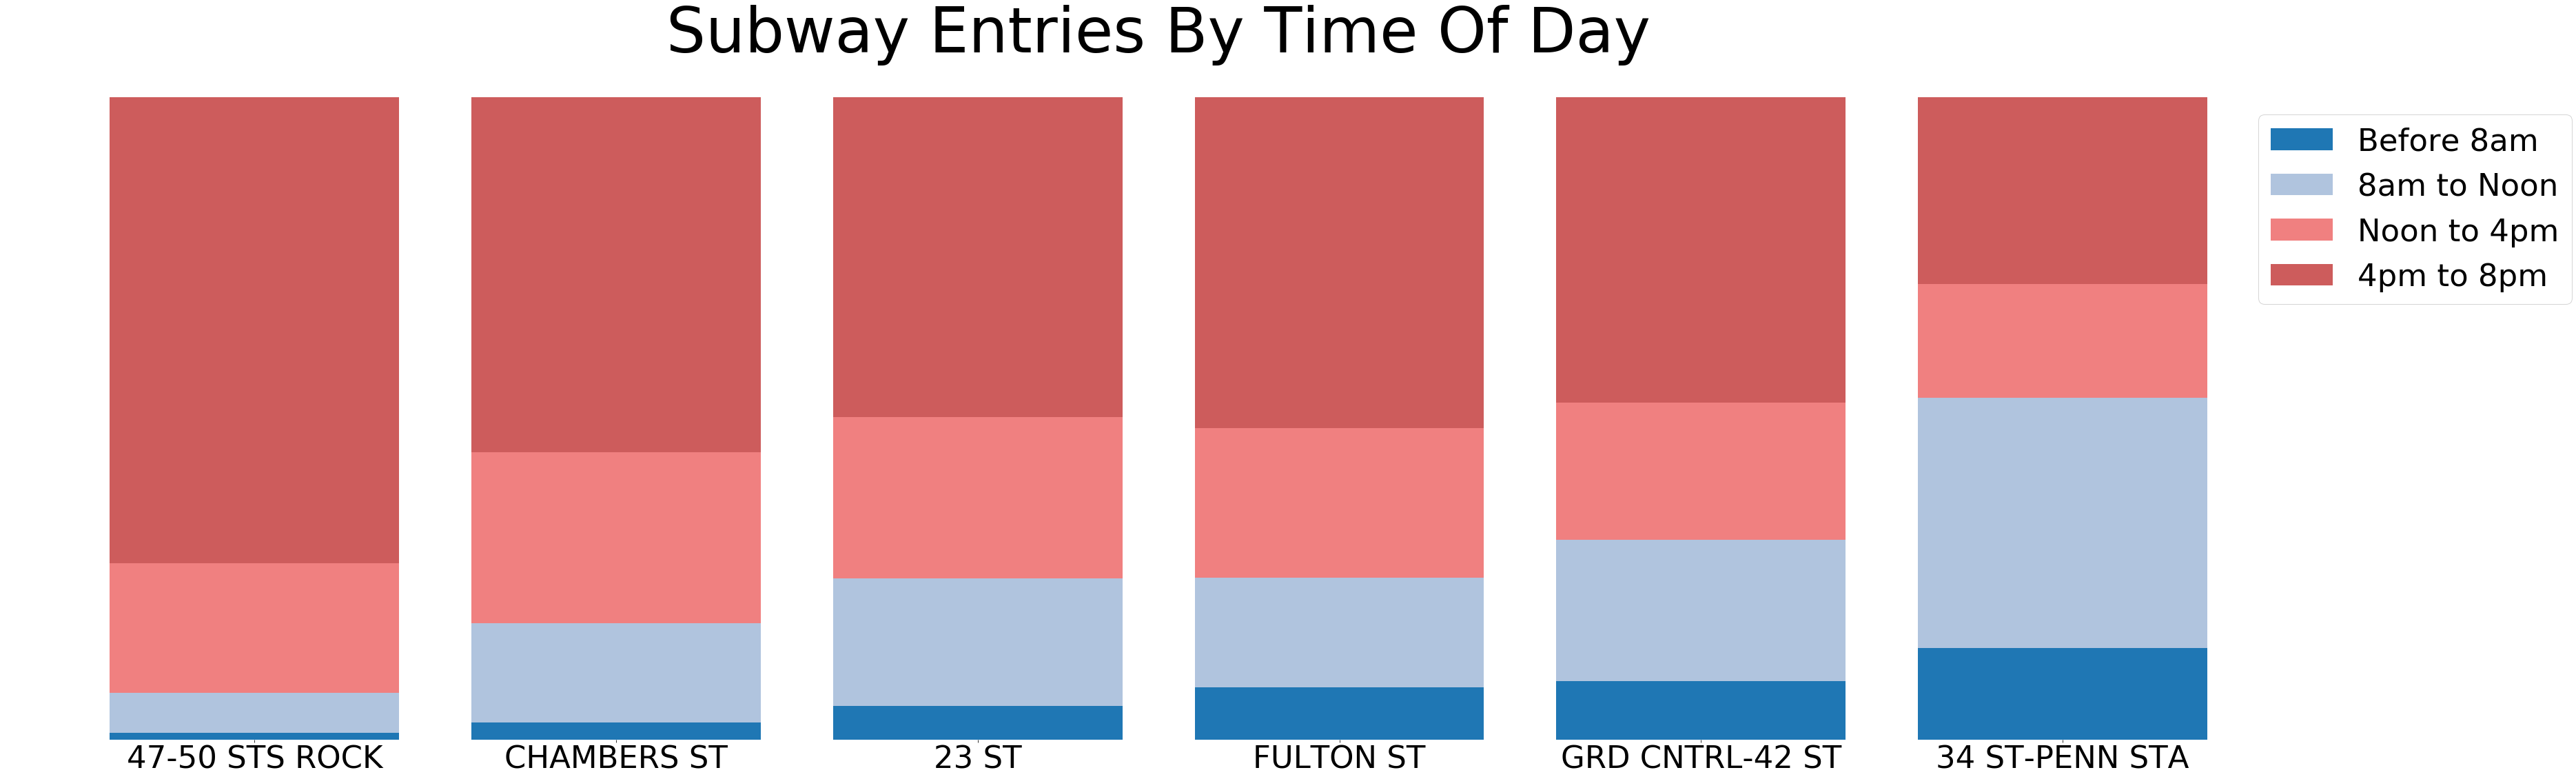

In [74]:
plt.figure(figsize=(60, 18))

plt.bar(by_percent.STATION, by_percent.early_morning, color='tab:blue')
plt.bar(by_percent.STATION, by_percent.late_morning, bottom=by_percent.early_morning, color='lightsteelblue')
plt.bar(by_percent.STATION, by_percent.afternoon, bottom=(by_percent.early_morning + by_percent.late_morning), color='lightcoral')
plt.bar(by_percent.STATION, by_percent.evening, bottom=(by_percent.early_morning + by_percent.late_morning + by_percent.afternoon), color='indianred')

plt.legend(['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'], bbox_to_anchor=(0.97, .95), fontsize='45')
plt.title('Subway Entries By Time Of Day', fontsize='90')
plt.xticks(fontsize='45')
plt.yticks([])
plt.box(on=None)

plt.savefig('../src/visualization/top_station_by_time_of_day.jpg', format='jpg', quality=95)